### Functions for downloading collection info and imagery

#### Format dates for STAC API query

In [1]:
from datetime import datetime, timedelta

input_date_str = "2022-03-01"
max_days_before = 21

max_date = datetime.strptime(input_date_str, "%Y-%m-%d") 
min_date = max_date - timedelta(days=max_days_before)

date_format = '%Y-%m-%dT%H:%M:%SZ'
stac_datetime = min_date.strftime(date_format) + '/' + max_date.strftime(date_format)
print(stac_datetime)

2022-02-08T00:00:00Z/2022-03-01T00:00:00Z


#### Query the STAC API for Sentinel-2 COGs

In [2]:
# Region in the Virunga mountains for DRC and Rwanda
geojson = {
    "type": "Polygon",
    "coordinates": [[
        (29.3688, -1.5118), 
        (29.3344, -1.4476), 
        (29.4516, -1.3251), 
        (29.6239, -1.3177), 
        (29.6114, -1.5008)
    ]]
}

In [3]:
import os
from pystac import ItemCollection
from pystac_client import Client
from shapely.geometry import box, shape


polygon = shape(geojson)
bbox = polygon.bounds
print(bbox)

client = Client.open("https://earth-search.aws.element84.com/v0")
search = client.search(
    bbox=bbox,
    collections=['sentinel-s2-l2a-cogs'], 
    datetime=stac_datetime,
    query={
        "eo:cloud_cover":{
            "lt":"30"
        },
    }
)

print(f"{search.matched()} items found")

if not os.path.exists("./data"):
    os.mkdir("./data")

collection = ItemCollection(items=search.items()) # this line causes items to iterate or something 
collection.save_object('./data/s2_collection.json')

(29.3344, -1.5118, 29.6239, -1.3177)
2 items found


#### Plot the region of interest and the Sentinel-2 image extents

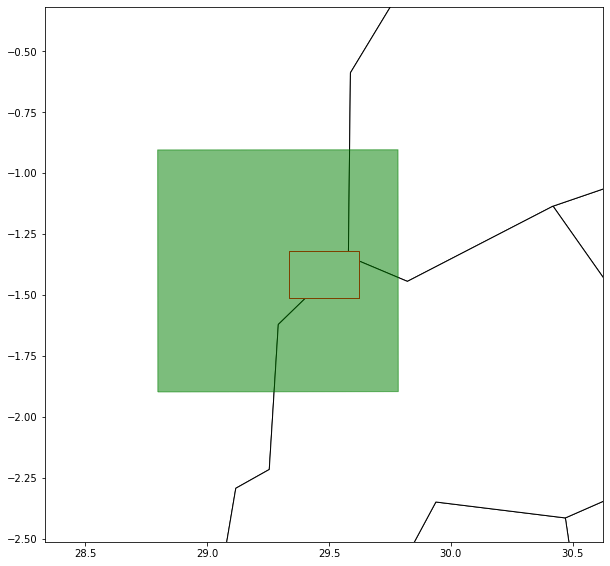

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

items = list(search.items_as_dicts())
s2_list = [[i['id'], shape(i['geometry'])] for i in items]
s2_list.append(['bounds', box(*polygon.bounds)])
s2_df = pd.DataFrame(s2_list, columns=["id", "polygon"])

s2_gdf = gpd.GeoDataFrame(s2_df, geometry=s2_df.polygon)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black', figsize=(10, 10)) # AxesSubplot

ax = s2_gdf[-1:].plot(ax=base, color='white', edgecolor='red', alpha=1.0)
ax = s2_gdf[:-1].plot(ax=base, color='green', edgecolor='green', alpha=0.3)

minx, miny, maxx, maxy = s2_gdf[-1:].geometry.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)
plt.show()

#### Download image from collection

In [8]:
import os

# this is important for parallel computing with dask

env = dict(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR', 
           AWS_NO_SIGN_REQUEST='YES',
           GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
           GDAL_SWATH_SIZE='200000000',
           VSI_CURL_CACHE_SIZE='200000000')

os.environ.update(env)

In [9]:
import os
from osgeo import gdal
import urllib.request
import xarray as xr


for item in list(collection):
    print(item.id)
    images = [item.assets[key].href for key in item.assets if key.startswith("B") or key == "SCL"]
    
    if not os.path.exists(f'./data/{item.id}'):
        os.mkdir(f'./data/{item.id}')
        
    for href in images:
        filename = href.split('/')[-1].split('.')[0]
        original_path = f'./data/{item.id}/{filename}.tif'
        cropped_path = f'./data/{item.id}/{filename}_cropped.tif'
        
        if not os.path.exists(original_path):
            print(f'\tdownloading: {filename}')
            urllib.request.urlretrieve(href, f'./data/{item.id}/{filename}.tif')
        
        if not os.path.exists(cropped_path):
            print(f'\tcropping: {filename}')
            gdal.Warp(cropped_path, original_path, dstSRS="EPSG:4326", outputBounds=bbox)

S2B_35MQU_20220226_0_L2A
S2A_35MQU_20220221_0_L2A


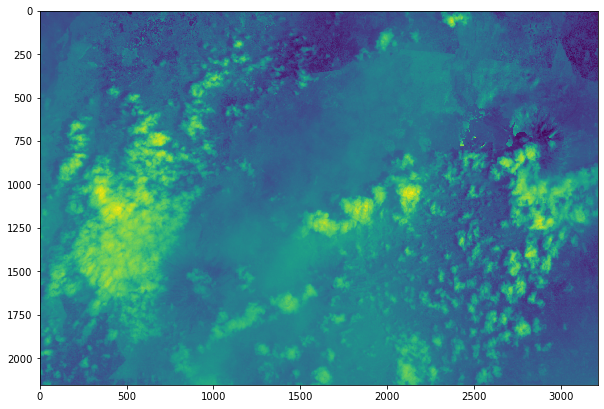

In [10]:
import rasterio
from matplotlib import pyplot as plt

src = rasterio.open('./data/S2B_35MQU_20220226_0_L2A/B08_cropped.tif')

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(src.read(1))
src.close()

In [ ]:
import glob
import xarray as xr


def load_image(parent_dir):
    
    files = glob.glob(f'{parent_dir}/B0[3-5]_cropped.tif')
    bands = [f.split('/')[-1].split('.')[0].replace("_cropped", "") for f in files]

    darrays = [xr.open_rasterio(href) for href in files]

    da = xr.concat(darrays, dim='band')
    da['band'] = bands
    return da
    

image_da = load_image("./data/S2B_35MQU_20220226_0_L2A")
print(image_da)
    